# 📌 PUNTO 1 – Carga y Preprocesamiento del Dataset para CNN Ligera

Cargamos los subconjuntos `train`, `val` y `test` desde `data/dataset_split`, utilizando:

- Resolución más baja (`128x128`) para reducir complejidad y acelerar el entrenamiento.
- Aumento de datos en `train_ds`.
- Normalización de imágenes al rango `[0, 1]`.

Este preprocesamiento es óptimo para una arquitectura CNN ligera entrenada desde cero, sin capas preentrenadas.


In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import os

# Parámetros
dataset_dir = os.path.join("..", "data", "dataset_split")
img_size = (128, 128)  # Menor resolución para CNN ligera
batch_size = 32
seed = 42

# Carga de datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_dir, "train"),
    image_size=img_size,
    batch_size=batch_size,
    seed=seed,
    label_mode="categorical"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_dir, "val"),
    image_size=img_size,
    batch_size=batch_size,
    seed=seed,
    label_mode="categorical"
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_dir, "test"),
    image_size=img_size,
    batch_size=batch_size,
    seed=seed,
    label_mode="categorical"
)

# Guardamos las clases
class_names = test_ds.class_names

# Normalización y aumento de datos
normalization_layer = layers.Rescaling(1./255)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.05, 0.05)
])

# Aplicar transformación (sin cache ni prefetch aún)
train_ds = train_ds.map(lambda x, y: (normalization_layer(data_augmentation(x)), y)).shuffle(1000)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


Found 6907 files belonging to 3 classes.
Found 1479 files belonging to 3 classes.
Found 1482 files belonging to 3 classes.


# 📌 PUNTO 2 – Definición de la Arquitectura CNN Ligera

Creamos una red convolucional desde cero, adaptada a imágenes de `128x128x3`. Incluye:

- Tres bloques `Conv2D + BatchNormalization + MaxPooling2D`.
- Capa `Flatten` seguida de `Dense(128)` con `Dropout` para evitar sobreajuste.
- Salida `Dense` con activación `softmax` para clasificación multiclase.

Es una arquitectura simple pero efectiva, ideal para entrenamiento en entornos con recursos limitados.


In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

# Número de clases (en tu caso: Atento, Bostezo, Eyes_Closed)
num_classes = len(class_names)

# Definición de la CNN ligera
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Dropout(0.25),
    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

# Compilación
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar resumen
model.summary()


c:\Users\isard\ProyectosLocales\env_multiclase_fatiga\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,923 (12.61 MB)

 Trainable params: 3,305,475 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

# 📌 PUNTO 3 – Entrenamiento del Modelo CNN Ligera

Entrenamos la red convolucional ligera con los siguientes callbacks:

- **EarlyStopping**: detiene el entrenamiento si no hay mejora en `val_loss`.
- **ModelCheckpoint**: guarda el mejor modelo según `val_loss`.
- **ReduceLROnPlateau**: dismin


In [3]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import datetime
import os
import pickle

# Ruta para guardar el modelo
cnn_model_name = f"modelo_cnn_ligera_3clases_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.keras"
cnn_model_path = os.path.join("..", "models", cnn_model_name)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(cnn_model_path, monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

# Entrenamiento
history_cnn = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

# Guardar historial
historial_cnn_path = os.path.join("..", "outputs", "historial_cnn_ligera.pkl")
with open(historial_cnn_path, 'wb') as f:
    pickle.dump(history_cnn.history, f)

print(f"✅ Entrenamiento completado. Modelo guardado en: {cnn_model_path}")


Epoch 1/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.4649 - loss: 1.9631
Epoch 1: val_loss improved from inf to 2.95400, saving model to ..\models\modelo_cnn_ligera_3clases_20250414_084959.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 72s 140ms/step - accuracy: 0.4651 - loss: 1.9601 - val_accuracy: 0.2177 - val_loss: 2.9540 - learning_rate: 0.0010
Epoch 2/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5041 - loss: 1.0074
Epoch 2: val_loss improved from 2.95400 to 1.00096, saving model to ..\models\modelo_cnn_ligera_3clases_20250414_084959.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 72s 139ms/step - accuracy: 0.5041 - loss: 1.0074 - val_accuracy: 0.5071 - val_loss: 1.0010 - learning_rate: 0.0010
Epoch 3/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.4983 - loss: 1.0049
Epoch 3: val_loss improved from 1.00096 to 0.97288, saving model to ..\models\modelo_cnn_ligera_3clases_20250414_084959.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 71s 139ms/step - accuracy: 0.4984 - loss: 1.0

# 📌 PUNTO 4 – Evaluación del Modelo CNN Ligera en el Conjunto de Test

Evaluamos el rendimiento del modelo sobre el conjunto de `test_ds`, completamente independiente del entrenamiento y validación.

Se generan:

- 🔢 **Reporte de clasificación**: muestra métricas detalladas (`precision`, `recall`, `f1-score`) para cada clase (`Atento`, `Bostezo`, `Eyes_Closed`).
- 🎯 **Matriz de confusión**: visualiza los aciertos y errores por clase.

Esto nos permite confirmar si el modelo ha aprendido a distinguir las clases relevantes en condiciones reales.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━

c:\Users\isard\ProyectosLocales\env_multiclase_fatiga\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\isard\ProyectosLocales\env_multiclase_fatiga\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\isard\ProyectosLocales\env_multiclase_fatiga\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

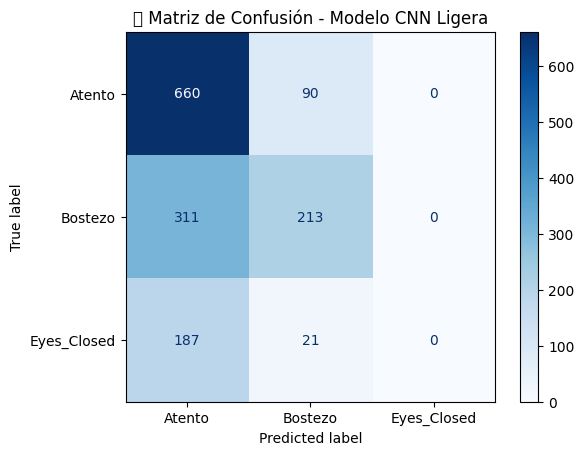

In [4]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

# Ruta al modelo CNN ligera (ajústala si cambió el nombre)
cnn_model_path = os.path.join("..", "models", "modelo_cnn_ligera_3clases_20250414_084959.keras")

# Cargar modelo
model = tf.keras.models.load_model(cnn_model_path)

# Preparar etiquetas reales y predichas
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Reporte de clasificación
print("📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("🔍 Matriz de Confusión - Modelo CNN Ligera")
plt.grid(False)
plt.show()


## 📌 Inspección visual – Imágenes reales de la clase `Eyes_Closed`

Mostramos una selección aleatoria de imágenes etiquetadas como `Eyes_Closed` en el conjunto de test. Esto nos permite:

- Verificar si los ojos realmente están cerrados.
- Evaluar la calidad de las muestras.
- Identificar posibles confusiones visuales con otras clases.

Esta revisión visual es clave para decidir si necesitamos reforzar esta clase con oversampling, aumento de datos o reetiquetado.


C:\Users\isard\AppData\Local\Temp\ipykernel_7500\3621729257.py:23: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


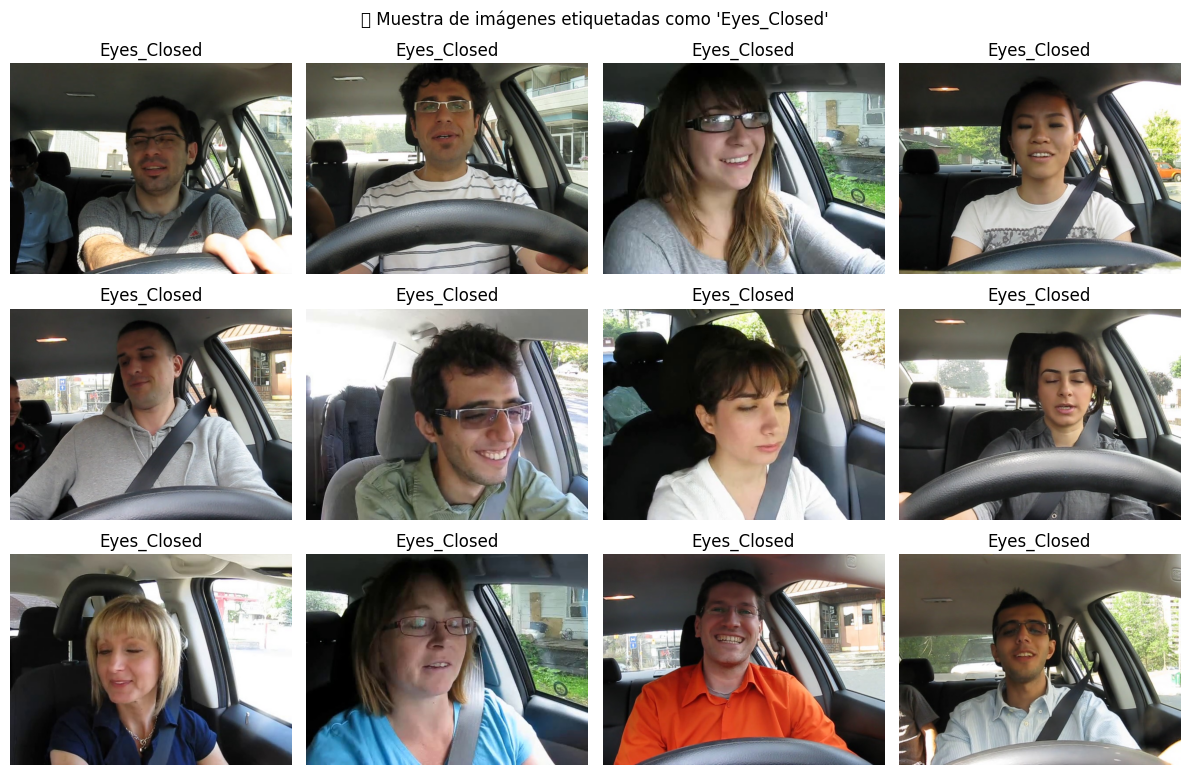

In [5]:
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

# Ruta a las imágenes de test/Eyes_Closed
eyes_closed_dir = os.path.join("..", "data", "dataset_split", "test", "Eyes_Closed")
images = os.listdir(eyes_closed_dir)

# Mostrar 12 imágenes aleatorias
sample_images = random.sample(images, min(12, len(images)))

plt.figure(figsize=(12, 8))
for idx, img_name in enumerate(sample_images):
    img_path = os.path.join(eyes_closed_dir, img_name)
    img = Image.open(img_path)

    plt.subplot(3, 4, idx + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Eyes_Closed")
plt.suptitle("🔍 Muestra de imágenes etiquetadas como 'Eyes_Closed'")
plt.tight_layout()
plt.show()
